Import Dependencies

In [43]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import matplotlib.colors as colors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import VotingClassifier

Load  data into a  DataFrame

In [44]:
from scipy.stats import stats

mb_raw_data = pd.read_csv('../../data/mann_bruker.txt', sep='\t')
mb_data_frame = pd.DataFrame(mb_raw_data)
# Delete all columns except Sequence, m/z, and CCS
mb_clean_frame = mb_data_frame[['CCS', 'Sequence', 'Charge', 'Mass', 'Length']]
mb_clean_frame = mb_clean_frame.groupby(['Sequence', 'Charge']).agg({'Mass':'median', 'CCS':'median','Length':'median'}).reset_index()

ccs_mean = mb_clean_frame['CCS'].mean()
ccs_std = mb_clean_frame['CCS'].std()

# delete all the old data frames to save memory
del mb_data_frame
del mb_raw_data
# Log transform CCS values
mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])
# randomize data set
mb_clean_frame = mb_clean_frame.sample(frac=1, random_state=1)


C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\945491732.py:16: DeprecationWarning: Please use `zscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  mb_clean_frame['CCS_z'] = stats.zscore(mb_clean_frame['CCS'])


Train Model

In [45]:
mb_frames_by_charge = mb_clean_frame.groupby("Charge")

# Split the data into input (m/z) and output (CCS) variables
X_list = {}
Y_list = {}
for name, group in mb_frames_by_charge:
    X_list[name] = (group[['Mass', 'Length']])
    Y_list[name] = (group['CCS_z'])

# Define the number of folds
k = 4

Perform k-fold cross validation

In [46]:
scores_dict = {}
for name, group in mb_frames_by_charge:
    print(f"Charge {name}")
    X = X_list[name]
    Y = Y_list[name]
    # Start logging time in ms without
    start_time = time.time()
    # Initialize the cross-validation object
    kf = KFold(n_splits=k)

    # Initialize a list to store the MSE for each fold
    mse_scores = []
    median_relative_errors = []
    r2_scores = []

    estimators = []
    # Perform k-fold cross-validation
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        #poly = PolynomialFeatures(degree=3)

        #X_train_poly = poly.fit_transform(X_train)

        model = LinearRegression(n_jobs=-1)

        model.fit(X_train, y_train)

        #X_test_poly = poly.transform(X_test)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
                # Convert predictions back to original scale
        y_pred_orig = y_pred * ccs_std + ccs_mean
        y_test_orig = y_test * ccs_std + ccs_mean

        # Calculate the scores for the current fold
        mse_scores.append(mean_squared_error(y_test_orig, y_pred_orig))
        median_relative_errors.append(np.median(np.abs((y_pred_orig - y_test_orig) / y_test_orig)))
        r2_scores.append(r2_score(y_test_orig, y_pred_orig))
        print("Fold:", len(mse_scores))

    #poly = PolynomialFeatures(degree=3)
    #X_poly = poly.fit_transform(X)
    # create the final model
    final_model = LinearRegression(n_jobs=-1)
    estimators.append(final_model.fit(X, Y))
    average_mse = np.mean(mse_scores)
    # Print the average MSE score
    print("Average Mean Squared Error:", average_mse)
    # Print the median of the relative errors for each fold
    #print("Median Relative Errors:", median_relative_errors)
    # print the average of the median relative errors
    print("Average Median Relative Error:", np.mean(median_relative_errors))
    # Print the R^2 scores for each fold
    #print("R^2 Scores:", r2_score)
    # Print the average R^2 score
    print("Average R^2 Score:", np.mean(r2_scores))
    # Calculate the elapsed time
    elapsed_time = time.time() - start_time

    # Print the elapsed time
    print(f'Time elapsed: {elapsed_time:.2f} seconds')

    scores_dict[name] = {"model": model, "avg_mse": average_mse, "avg_mean_rel_err": np.mean(median_relative_errors), "avg_r2": np.mean(r2_scores), "num_entries": len(group)}

Charge 1
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 9.595823919917654e-74
Average Median Relative Error: 0.0177763773589288
Average R^2 Score: 0.551287300174985
Time elapsed: 0.08 seconds
Charge 2
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 6.145824330022443e-73
Average Median Relative Error: 0.028089302496407075
Average R^2 Score: 0.9072466921898514
Time elapsed: 0.07 seconds
Charge 3
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 2.592322903411059e-72
Average Median Relative Error: 0.03815016684400951
Average R^2 Score: 0.7810220645320307
Time elapsed: 0.06 seconds
Charge 4
Fold: 1
Fold: 2
Fold: 3
Fold: 4
Average Mean Squared Error: 6.755263700689716e-72
Average Median Relative Error: 0.036619594741854236
Average R^2 Score: 0.6494935697240676
Time elapsed: 0.05 seconds


In [47]:
print(scores_dict)
print("Overall Scores:")
avg_mse = 0
avg_mean_rel_err = 0
avg_r2 = 0
for charge in scores_dict:
    scores = scores_dict[charge]
    num_entries = scores["num_entries"]
    avg_mse += scores["avg_mse"] * num_entries
    avg_mean_rel_err += scores["avg_mean_rel_err"] * num_entries
    avg_r2 += scores["avg_r2"] * num_entries


print(len(mb_clean_frame))
avg_mse = avg_mse / len(mb_clean_frame)
avg_mean_rel_err = avg_mean_rel_err / len(mb_clean_frame)
avg_r2 = avg_r2 / len(mb_clean_frame)
print("Average Mean Squared Error: " + str(avg_mse))
print("Average Mean Relative Error: " + str(avg_mean_rel_err))
print("Average R^2: " + str(avg_r2))

{1: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 9.595823919917654e-74, 'avg_mean_rel_err': 0.0177763773589288, 'avg_r2': 0.551287300174985, 'num_entries': 65044}, 2: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 6.145824330022443e-73, 'avg_mean_rel_err': 0.028089302496407075, 'avg_r2': 0.9072466921898514, 'num_entries': 119534}, 3: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 2.592322903411059e-72, 'avg_mean_rel_err': 0.03815016684400951, 'avg_r2': 0.7810220645320307, 'num_entries': 41779}, 4: {'model': LinearRegression(n_jobs=-1), 'avg_mse': 6.755263700689716e-72, 'avg_mean_rel_err': 0.036619594741854236, 'avg_r2': 0.6494935697240676, 'num_entries': 5254}}
Overall Scores:
231611
Average Mean Squared Error: 9.649879251071664e-73
Average Mean Relative Error: 0.02720142197429856
Average R^2: 0.7786655957887034


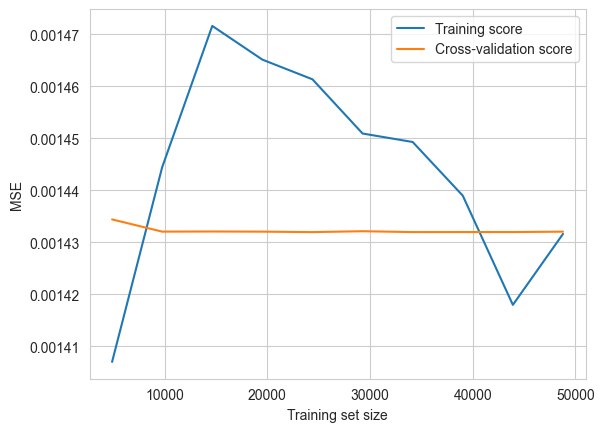

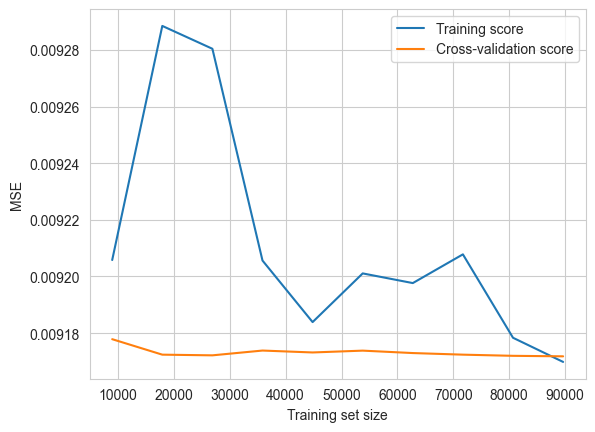

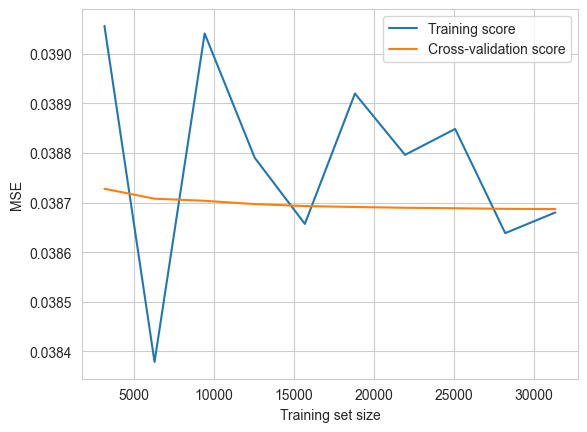

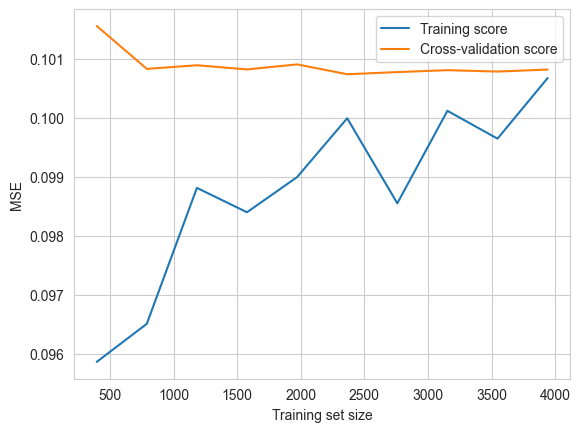

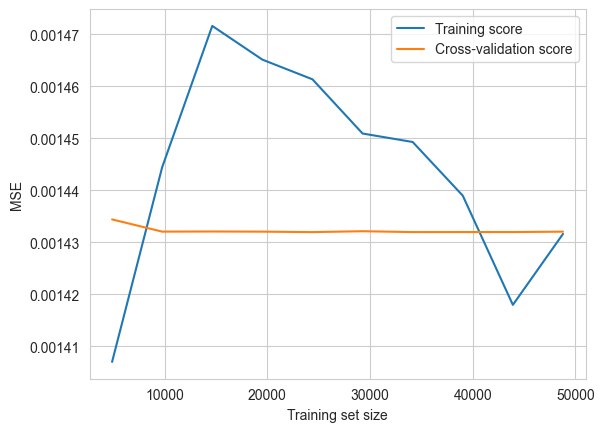

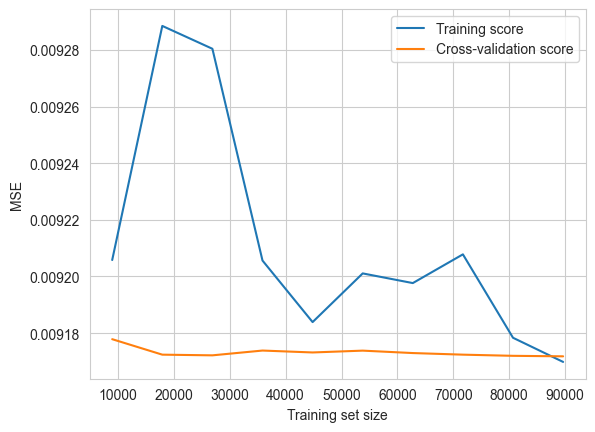

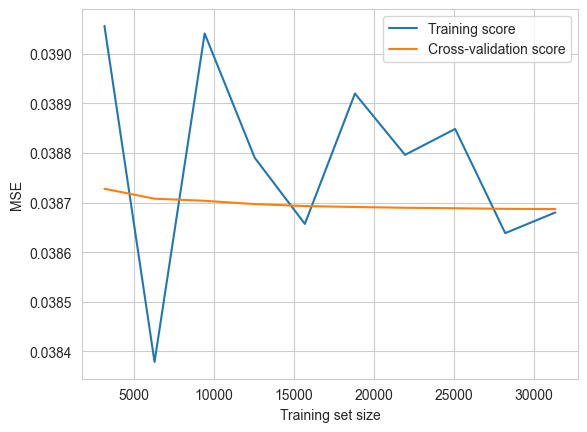

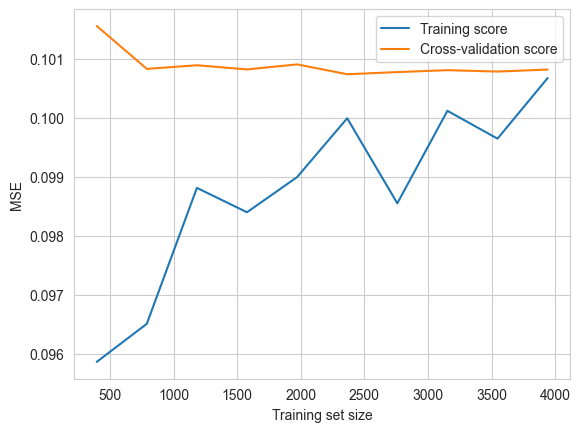

In [48]:
from sklearn.model_selection import learning_curve
for name, group in mb_frames_by_charge:
    X = X_list[name]
    y = Y_list[name]
    # Define the sizes of the training sets to use
    train_sizes = np.linspace(0.1, 1.0, 10)

    # Calculate the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        LinearRegression(n_jobs=-1),
        X,
        y,
        train_sizes=train_sizes,
        cv=k,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Calculate the average training and test scores
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
    plt.xlabel('Training set size')
    plt.ylabel('MSE')
    plt.legend()
    plt.show()


Feature: 0, Score: -0.00044
Feature: 1, Score: 0.01034


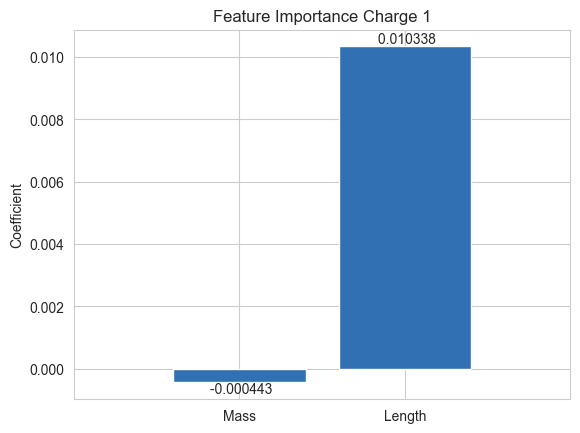

Feature: 0, Score: -0.00067
Feature: 1, Score: 0.00184


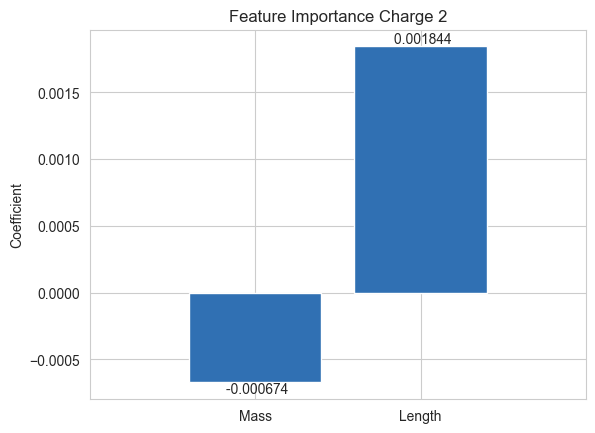

Feature: 0, Score: -0.00051
Feature: 1, Score: -0.01396


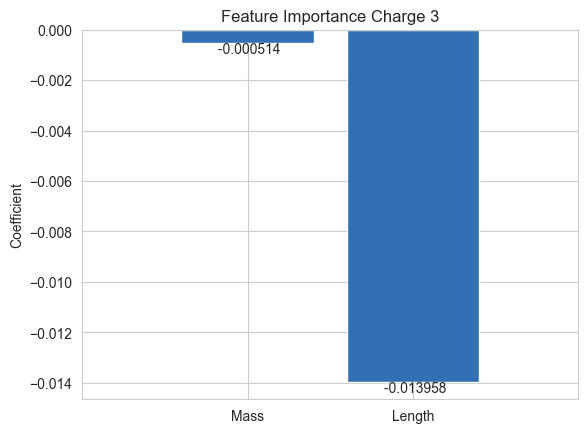

Feature: 0, Score: -0.00061
Feature: 1, Score: -0.00592


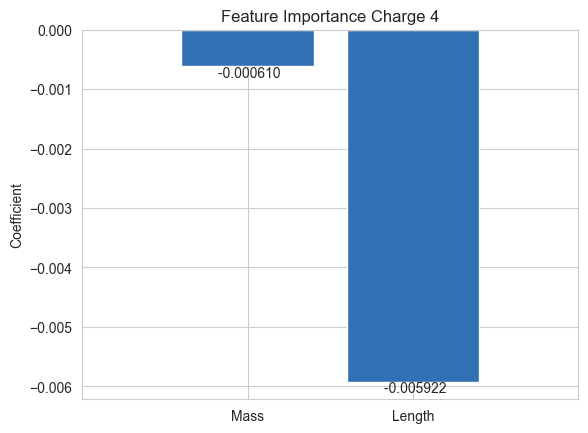

Feature: 0, Score: -0.00044
Feature: 1, Score: 0.01034


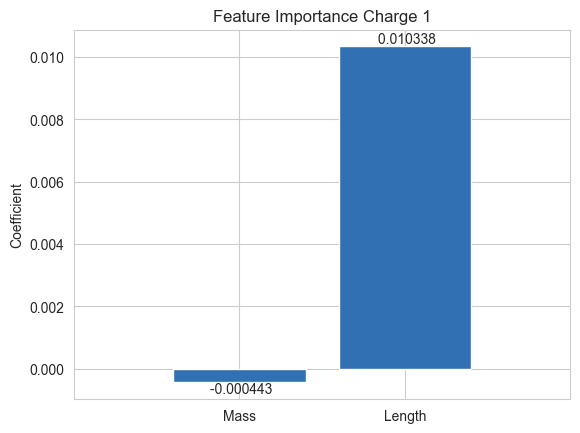

Feature: 0, Score: -0.00067
Feature: 1, Score: 0.00184


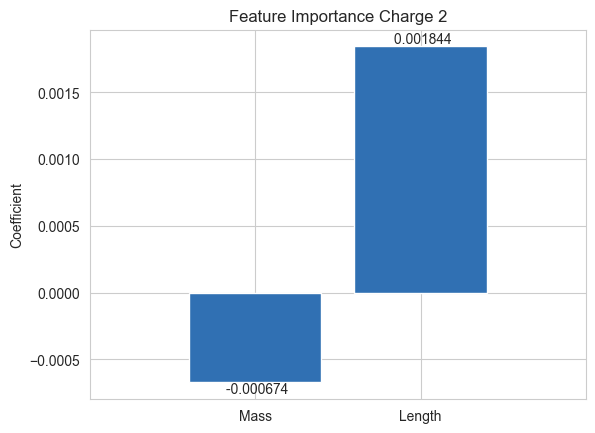

Feature: 0, Score: -0.00051
Feature: 1, Score: -0.01396


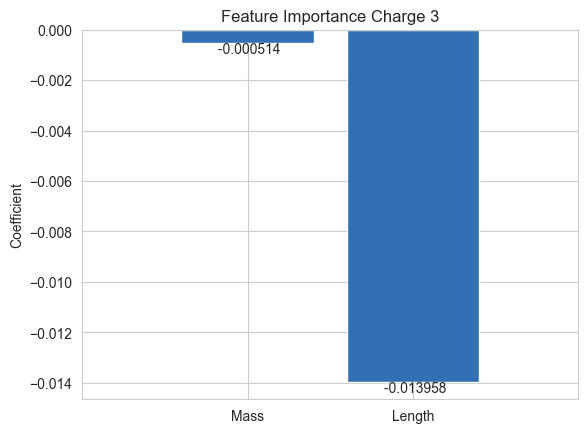

Feature: 0, Score: -0.00061
Feature: 1, Score: -0.00592


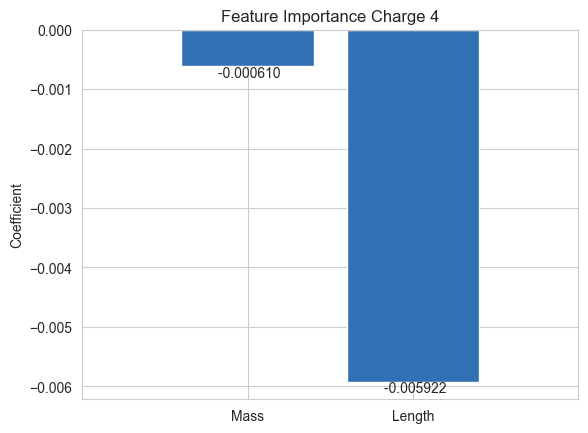

In [49]:
for name, group in mb_frames_by_charge:
    importance = scores_dict[name]["model"].coef_
    # summarize feature importance
    for i,v in enumerate(importance):
     print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance, color="#3070B3")
    plt.ylabel("Coefficient")
    plt.title("Feature Importance Charge " + str(name))
    features = X.columns
    plt.xticks(range(X.shape[1]), model.feature_names_in_, rotation=0)
    plt.xlim([-1, X.shape[1]])
    for i, v in enumerate(importance):
        va = 'bottom' if v >= 0 else 'top'
        plt.text(i, v, " %.6f" % v, ha='center', va=va)
    plt.show()

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\1659317561.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\1659317561.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\1659317561.py:8: SettingWithCo

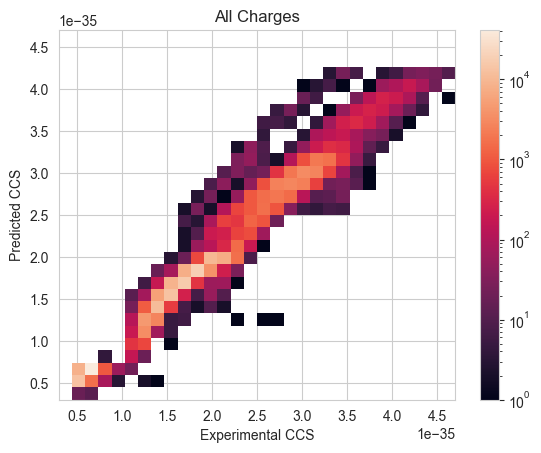

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\1659317561.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\1659317561.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\1659317561.py:8: SettingWithCo

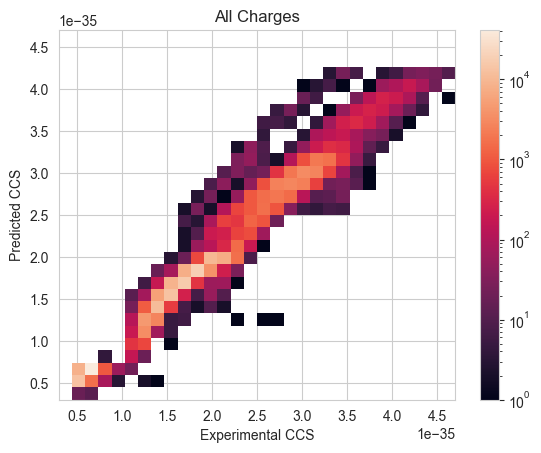

In [50]:
models = {1: scores_dict[1]["model"], 2: scores_dict[2]["model"], 3: scores_dict[3]["model"], 4: scores_dict[4]["model"]}

x = []
y = []
for key in models:
    mb_charge_frame = mb_clean_frame[mb_clean_frame['Charge'] == key]
    # Predict the CCS of the peptides in the data frame
    mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])

    # Reverse the z-score transformation
    mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean

    ccs_data = mb_charge_frame["CCS"].to_numpy()
    predicted_ccs_data = mb_charge_frame["Predicted CCS"].to_numpy()

    x += mb_charge_frame["CCS"].tolist()
    y += mb_charge_frame["Predicted CCS"].tolist()


plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(), range=((3*1e-36, 4.7*1e-35), (3*1e-36, 4.7*1e-35)))
plt.colorbar()
plt.title("All Charges")
plt.xlabel("Experimental CCS")
plt.ylabel("Predicted CCS")
plt.show()

Save the model

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


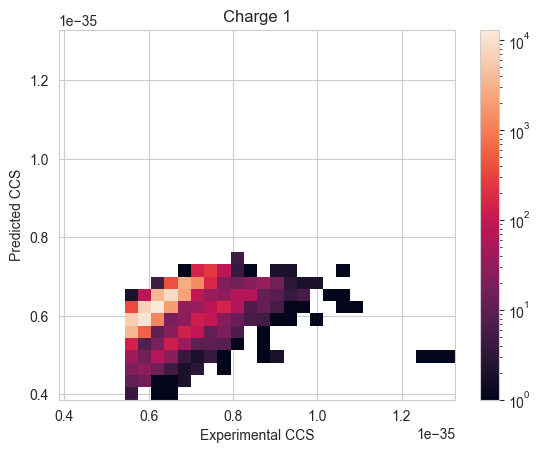

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


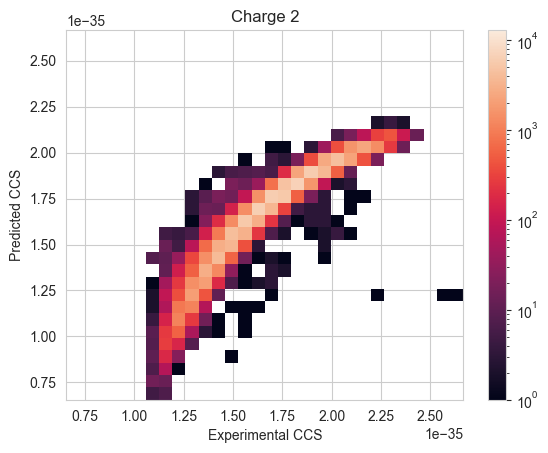

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


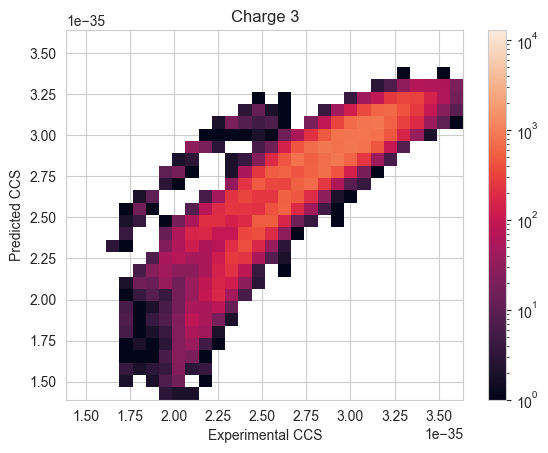

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


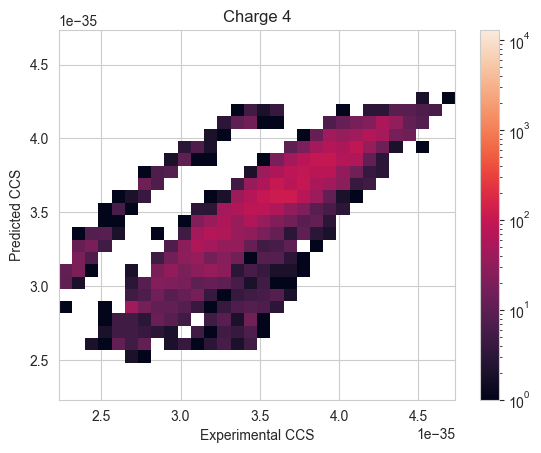

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


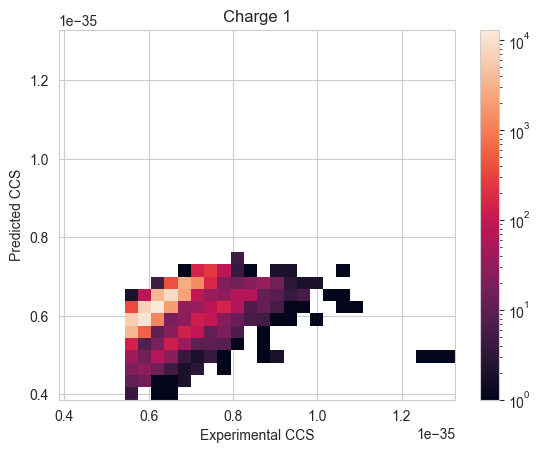

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


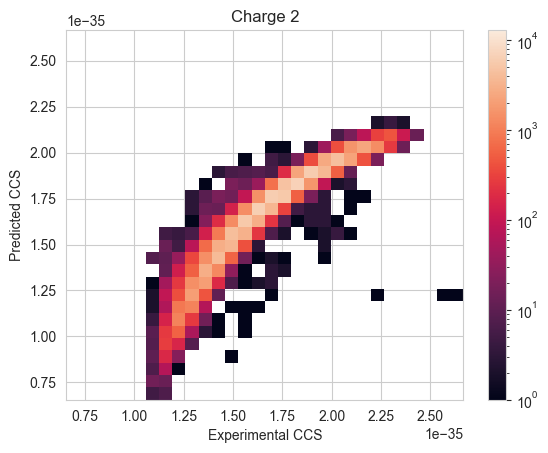

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


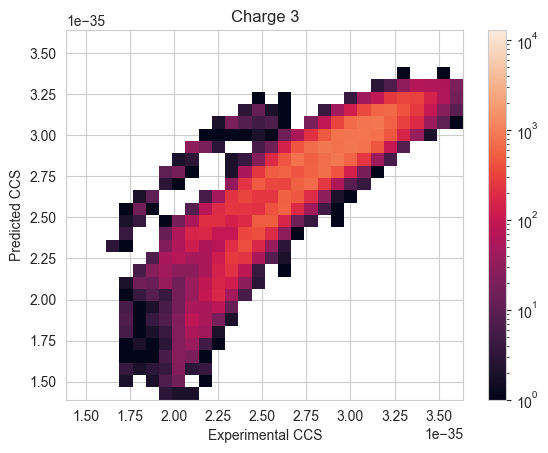

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\3739620675.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


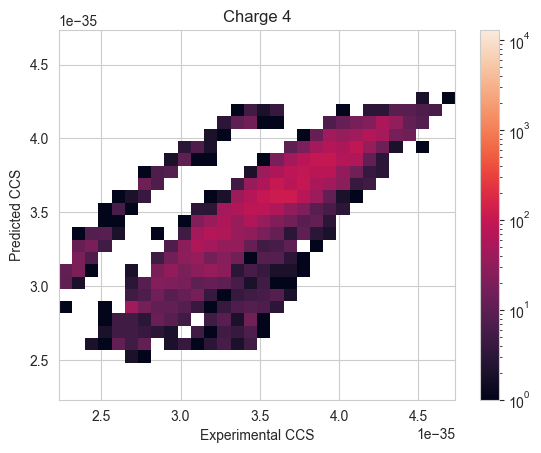

In [51]:
for key in models:
    mb_charge_frame = mb_clean_frame[mb_clean_frame['Charge'] == key]

    # Predict the CCS of the peptides in the data frame
    mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])

    # Reverse the z-score transformation
    mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean

    ccs_data = mb_charge_frame["CCS"].to_numpy()
    predicted_ccs_data = mb_charge_frame["Predicted CCS"].to_numpy()

    x = mb_charge_frame["CCS"]
    y = mb_charge_frame["Predicted CCS"]

    plt_min = [mb_charge_frame["CCS"].min(), mb_charge_frame["Predicted CCS"].min()]
    plt_max = [mb_charge_frame["CCS"].max(), mb_charge_frame["Predicted CCS"].max()]

    range_min = 0
    range_max = 0

    if plt_min[0] < plt_min[1]:
        range_min = plt_min[0]
    else:
        range_min = plt_min[1]

    if plt_max[0] > plt_max[1]:
        range_max = plt_max[0]
    else:
        range_max = plt_max[1]

    if key == 100:
        plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(vmax=1.1*(10**4)), range=((0, 1.4*1e-35), (0, 1.4*1e-35)))
    else:
        plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(vmax=1.3*(10**4)), range=((range_min, range_max), (range_min, range_max)))
    plt.colorbar()
    plt.title(f"Charge {key}")
    plt.xlabel("Experimental CCS")
    plt.ylabel("Predicted CCS")
    plt.show()

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


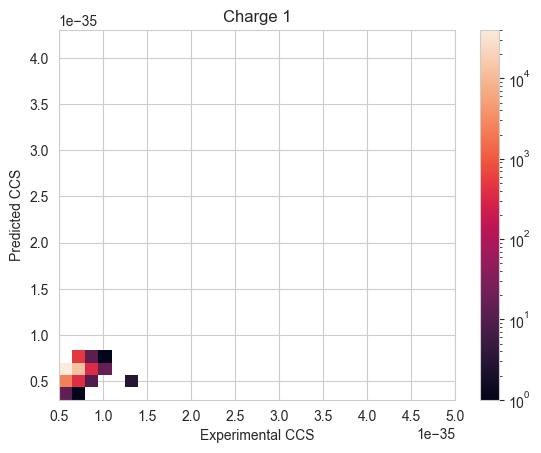

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


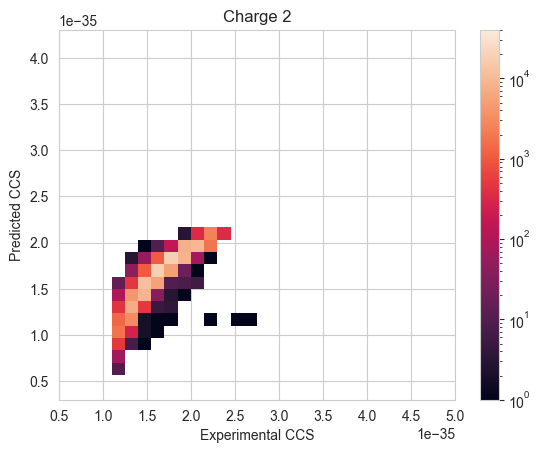

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


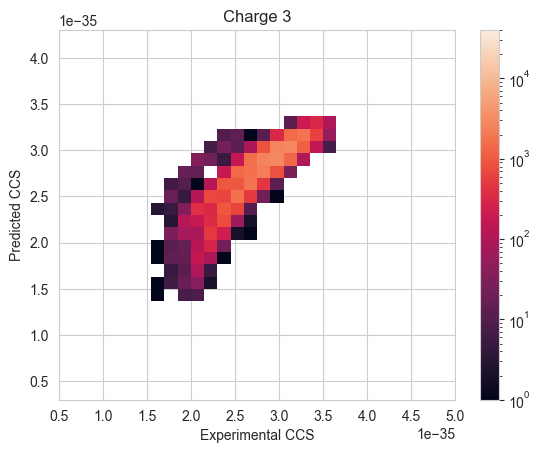

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


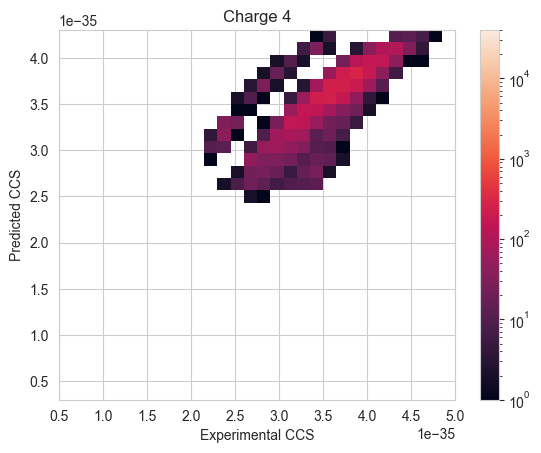

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


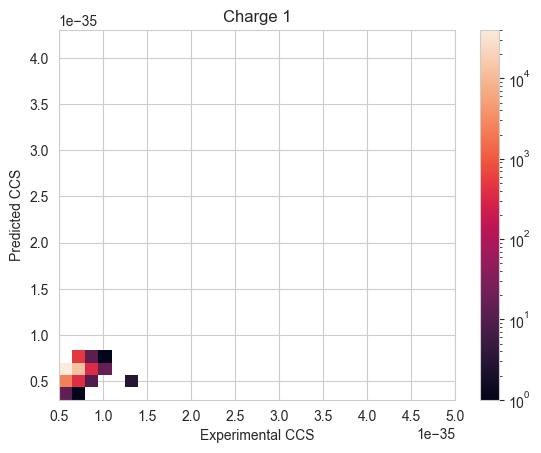

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


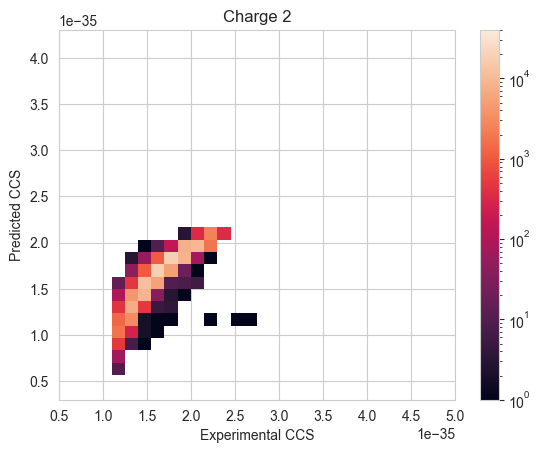

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


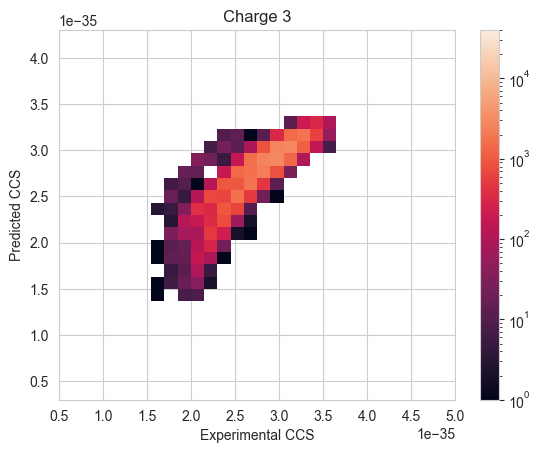

C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])
C:\Users\Fabian Mathis\AppData\Local\Temp\ipykernel_11844\2293035610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean


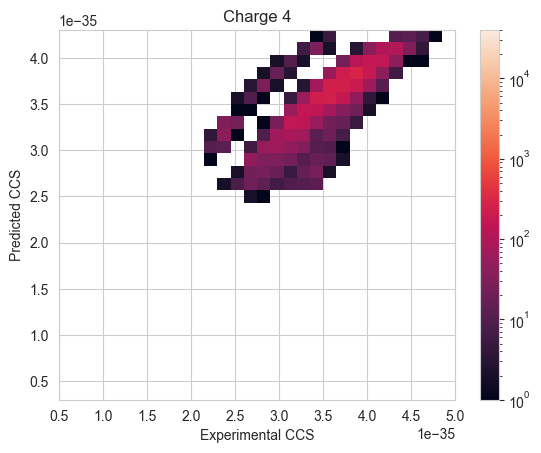

In [52]:
for key in models:
    mb_charge_frame = mb_clean_frame[mb_clean_frame['Charge'] == key]
    # Predict the CCS of the peptides in the data frame
    mb_charge_frame['Predicted CCS'] = models[key].predict(mb_charge_frame[['Mass', 'Length']])

    # Reverse the z-score transformation
    mb_charge_frame['Predicted CCS'] = mb_charge_frame['Predicted CCS'] * ccs_std + ccs_mean

    ccs_data = mb_charge_frame["CCS"].to_numpy()
    predicted_ccs_data = mb_charge_frame["Predicted CCS"].to_numpy()

    x = mb_charge_frame["CCS"]
    y = mb_charge_frame["Predicted CCS"]

    plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(vmax=4*(10**4)), range=((0.5*1e-35, 5*1e-35), (3*1e-36, 4.3*1e-35)))
    plt.colorbar()
    plt.title(f"Charge {key}")
    plt.xlabel("Experimental CCS")
    plt.ylabel("Predicted CCS")
    plt.show()

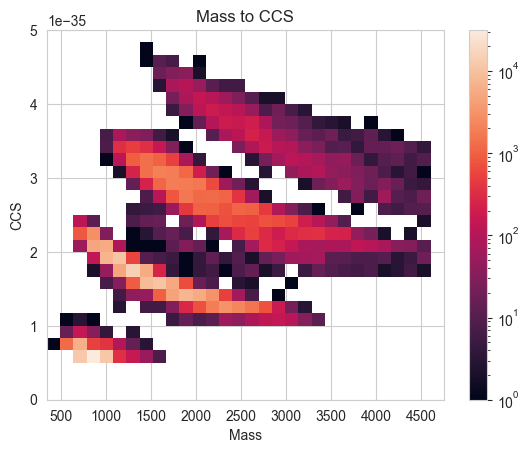

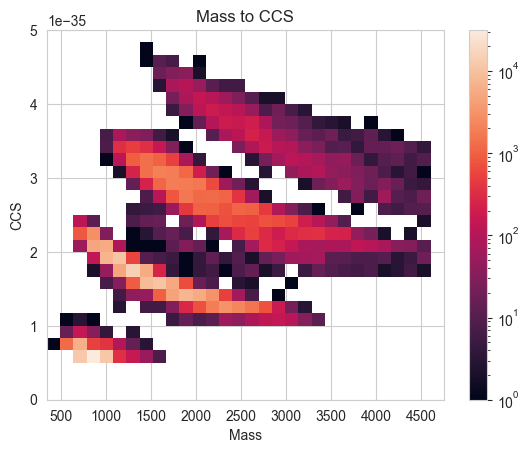

In [53]:
x = mb_clean_frame["Mass"]
y = mb_clean_frame["CCS"]

plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(), range=((350, 4750), (0, 5*1e-35)))
plt.colorbar()
plt.title(f"Mass to CCS")
plt.xlabel("Mass")
plt.ylabel("CCS")
plt.show()

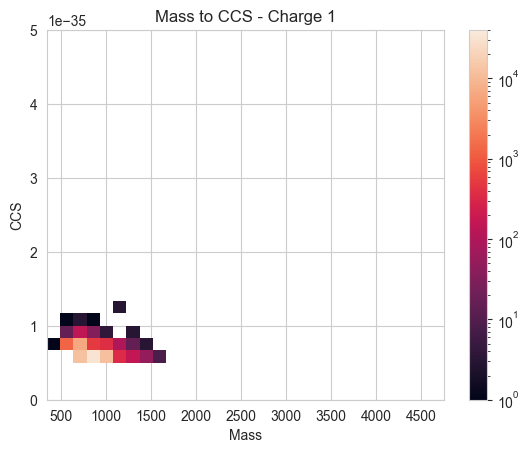

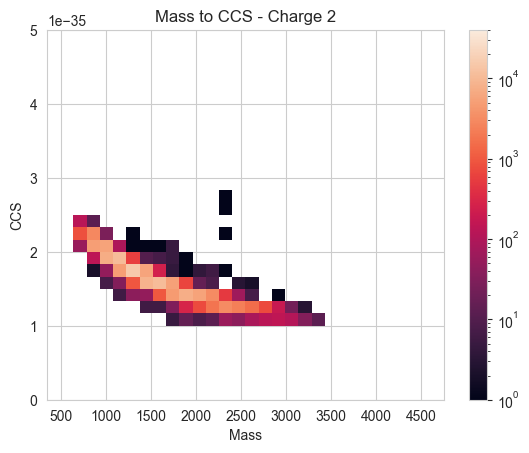

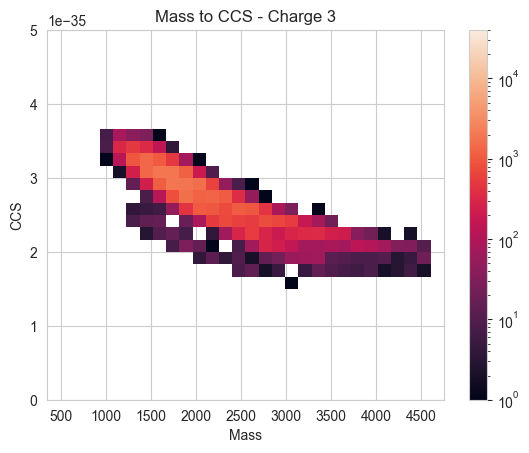

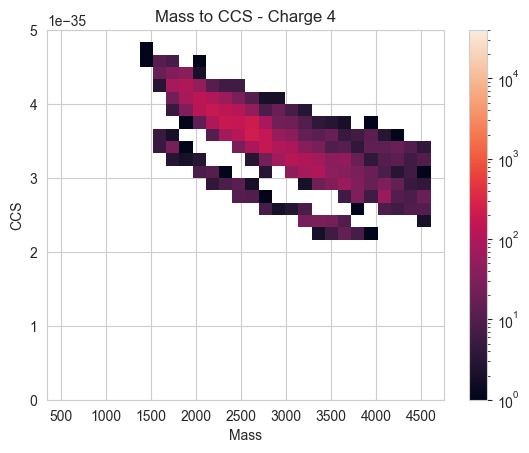

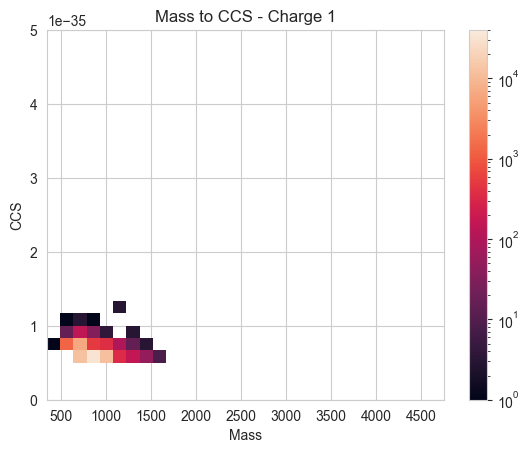

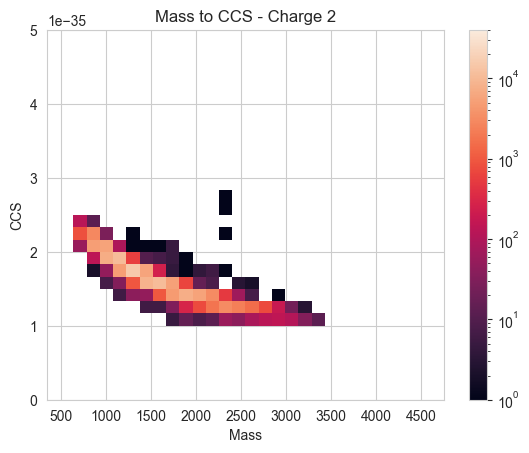

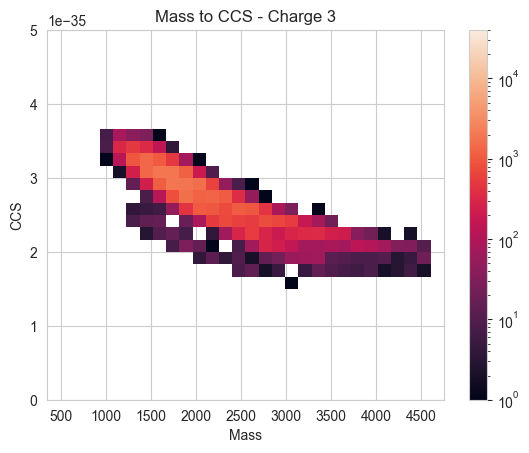

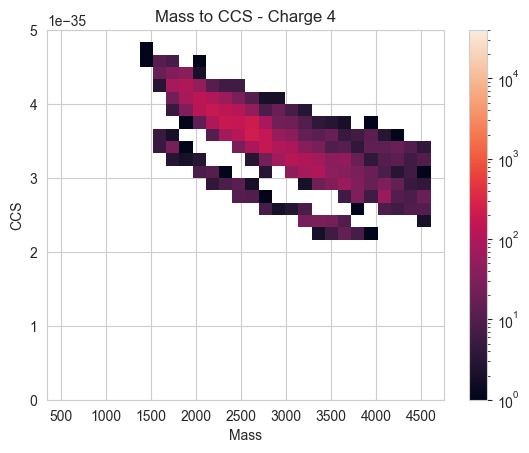

In [54]:
for name, group in mb_frames_by_charge:
    x = group["Mass"]
    y = group["CCS"]

    plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(vmax=4*(10**4)), range=((350, 4750), (0, 5*1e-35)))
    plt.colorbar()
    plt.title(f"Mass to CCS - Charge {name}")
    plt.xlabel("Mass")
    plt.ylabel("CCS")
    plt.show()

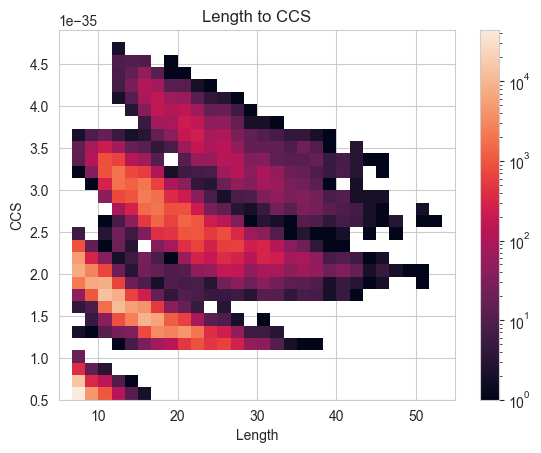

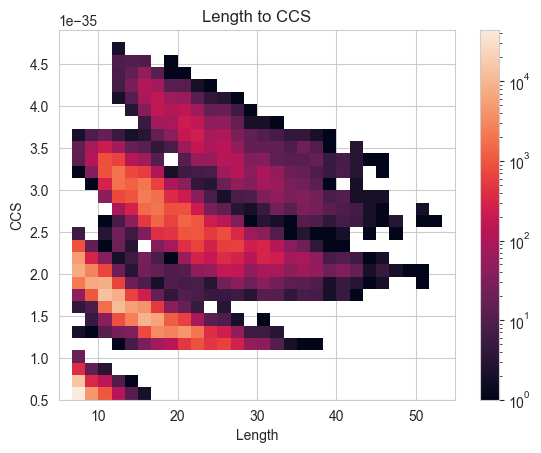

In [55]:
x = mb_clean_frame["Length"]
y = mb_clean_frame["CCS"]

plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(), range=((5, 55), (0.5*1e-35, 4.9*1e-35)))
plt.colorbar()
plt.title(f"Length to CCS")
plt.xlabel("Length")
plt.ylabel("CCS")
plt.show()

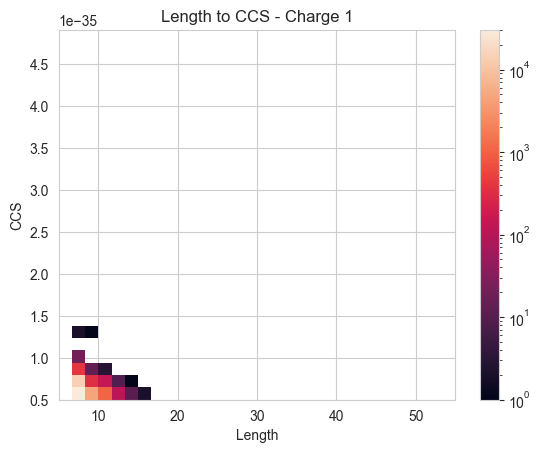

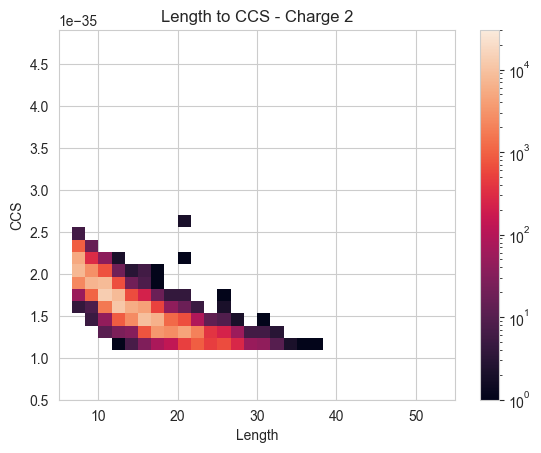

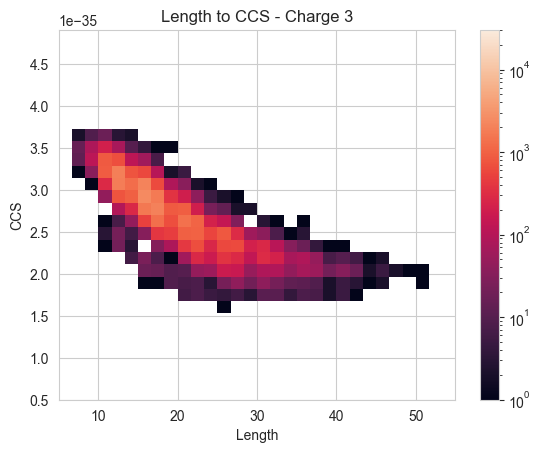

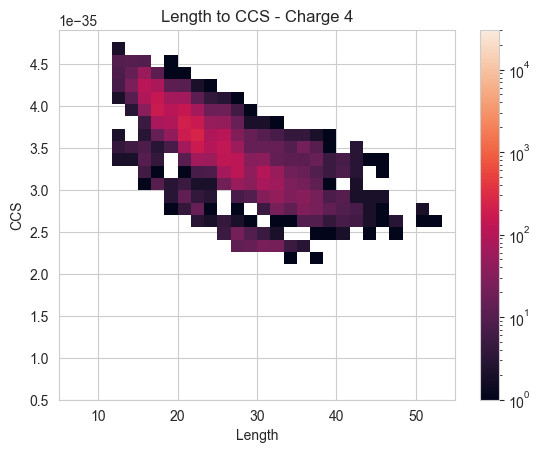

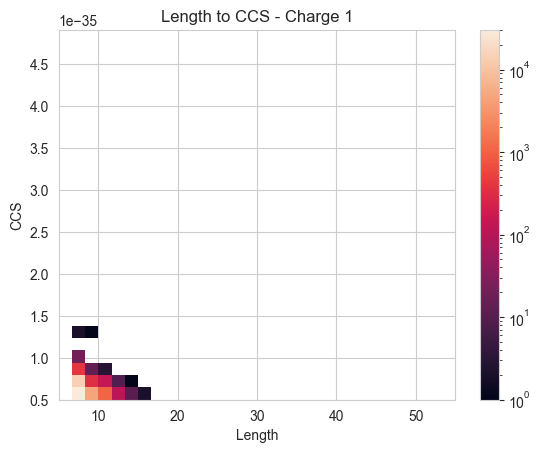

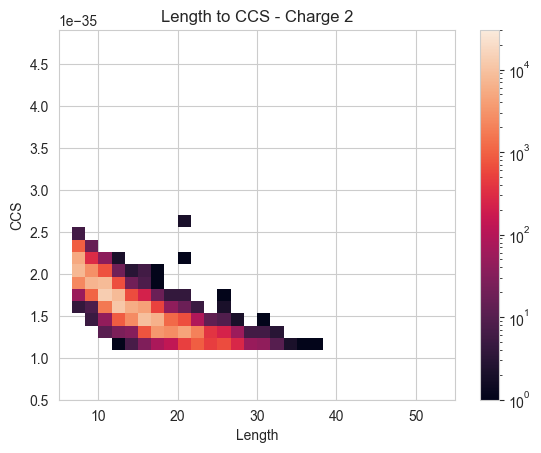

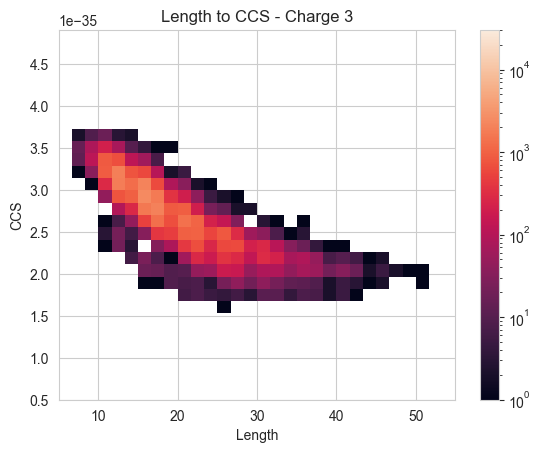

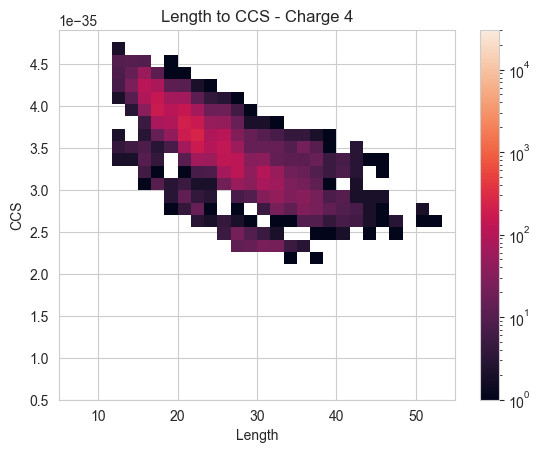

In [56]:
for name, group in mb_frames_by_charge:
    x = group["Length"]
    y = group["CCS"]

    plt.hist2d(x, y, bins=[30,30], norm=colors.LogNorm(vmax=3*(10**4)), range=((5, 55), (0.5*1e-35, 4.9*1e-35)))
    plt.colorbar()
    plt.title(f"Length to CCS - Charge {name}")
    plt.xlabel("Length")
    plt.ylabel("CCS")
    plt.show()

In [57]:
for name, group in mb_frames_by_charge:

    # Add a column to the data frame with the length of each peptide sequence
    group['Sequence Length'] = group['Sequence'].apply(lambda x: len(x))
    # Predict the CCS of the peptides in the data frame
    group['Predicted CCS'] = final_model.predict(group[[ 'Mass', 'Length']])
    # Reverse the log transformation
    group['Predicted CCS'] = np.exp(group['Predicted CCS'])

Save the model to a file

In [58]:
#filename = '../../models/lin_reg/lin_reg.pkl'
#pickle.dump(model, open(filename, 'wb'))